In [ ]:
import os
import math
import random
from pathlib import Path
from typing import Tuple, Optional, List, Dict

import numpy as np
from tqdm.notebook import tqdm
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split

from datasets import load_dataset
from torchvision import transforms, utils as tv_utils
from torchvision.transforms import Compose, Resize, RandomHorizontalFlip, ToTensor

In [ ]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")
print("Device:", DEVICE)

Device: cuda


In [ ]:
HF_DATASET_ID = "valhalla/emoji-dataset"
IMAGE_SIZE = 64
NUM_WORKERS =  2

EPOCHS = 200
LR = 2e-4
CODEBOOK_RESET_INTERVAL = 5
EMA_DECAY = 0.99

BATCH_SIZE = 128
HIDDEN_DIMS = [128, 256]
LATENT_DIM = 256
NUM_EMBEDDINGS = 512
COMMITMENT_COST = 0.25
RES_BLOCKS = 2
CHECKPOINT_PATH = "vqvae_checkpoint.pt"
BEST_MODEL_PATH = "vqvae_best.pt"

In [ ]:
class HFDatasetWrapper(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.ds = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[int(idx)]
        img = item["image"]
        if self.transform:
            img = self.transform(img)
        label = item.get("text", "")
        return img, label

In [ ]:
def get_hf_dataloader(dataset_id=HF_DATASET_ID, split="train", image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True):
    print(f"Loading HuggingFace dataset `{dataset_id}` split='{split}' ...")
    hf_ds = load_dataset(dataset_id, split=split)
    print(f"Dataset loaded. Examples: {len(hf_ds)}")
    transform = Compose([
        Resize((image_size, image_size)),
        RandomHorizontalFlip(),
        ToTensor(),
    ])
    wrapped = HFDatasetWrapper(hf_ds, transform=transform)
    loader = DataLoader(wrapped, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, pin_memory=True)
    return loader

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1)
        self.conv2 = nn.Conv2d(channels, channels, 3, padding=1)
        self.norm1 = nn.BatchNorm2d(channels)
        self.norm2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        x = F.relu(self.norm1(self.conv1(x)))
        x = self.norm2(self.conv2(x))
        return F.relu(x + residual)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, in_channels, hidden_dims, latent_dim, num_res_blocks):
        super().__init__()
        modules = []
        modules.append(nn.Sequential(
            nn.Conv2d(in_channels, hidden_dims[0], 4, stride=2, padding=1),
            nn.BatchNorm2d(hidden_dims[0]),
            nn.ReLU()
        ))

        for i in range(len(hidden_dims) - 1):
            for _ in range(num_res_blocks):
                modules.append(ResidualBlock(hidden_dims[i]))
            modules.append(nn.Sequential(
                nn.Conv2d(hidden_dims[i], hidden_dims[i+1], 4, stride=2, padding=1),
                nn.BatchNorm2d(hidden_dims[i+1]),
                nn.ReLU()
            ))

        for _ in range(num_res_blocks):
            modules.append(ResidualBlock(hidden_dims[-1]))

        modules.append(nn.Sequential(
            nn.Conv2d(hidden_dims[-1], latent_dim, 1),
            nn.BatchNorm2d(latent_dim)
        ))

        self.encoder = nn.Sequential(*modules)

    def forward(self, x):
        return self.encoder(x)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dims, out_channels, num_res_blocks):
        super().__init__()
        modules = []

        modules.append(nn.Sequential(
            nn.Conv2d(latent_dim, hidden_dims[0], 1),
            nn.BatchNorm2d(hidden_dims[0]),
            nn.ReLU()
        ))
        for _ in range(num_res_blocks):
            modules.append(ResidualBlock(hidden_dims[0]))

        for i in range(len(hidden_dims) - 1):
            modules.append(nn.Sequential(
                nn.ConvTranspose2d(hidden_dims[i], hidden_dims[i+1], 4, stride=2, padding=1),
                nn.BatchNorm2d(hidden_dims[i+1]),
                nn.ReLU()
            ))
            for _ in range(num_res_blocks):
                modules.append(ResidualBlock(hidden_dims[i+1]))

        modules.append(nn.Sequential(
            nn.ConvTranspose2d(hidden_dims[-1], hidden_dims[-1] // 2, 4, stride=2, padding=1),
            nn.BatchNorm2d(hidden_dims[-1] // 2),
            nn.ReLU()
        ))

        modules.append(nn.Sequential(
            nn.Conv2d(hidden_dims[-1] // 2, out_channels, 3, padding=1),
            nn.Sigmoid()
        ))

        self.decoder = nn.Sequential(*modules)

    def forward(self, z):
        return self.decoder(z)

In [ ]:
class EMAQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay=0.99):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.commitment_cost = commitment_cost
        self.decay = decay

        self.register_buffer('embedding', torch.randn(num_embeddings, embedding_dim))

        self.register_buffer('cluster_size', torch.zeros(num_embeddings))
        self.register_buffer('embedding_avg', torch.randn(num_embeddings, embedding_dim))
        self.register_buffer('code_usage_counter', torch.zeros(num_embeddings, dtype=torch.long))

    def forward(self, z):
        z_permuted = z.permute(0, 2, 3, 1).contiguous()
        z_flattened = z_permuted.view(-1, self.embedding_dim)

        distances = (torch.sum(z_flattened**2, dim=1, keepdim=True)
                    + torch.sum(self.embedding**2, dim=1)
                    - 2 * torch.matmul(z_flattened, self.embedding.t()))

        encoding_indices = torch.argmin(distances, dim=1)
        encodings = F.one_hot(encoding_indices, self.num_embeddings).float()

        quantized = torch.matmul(encodings, self.embedding).view(z_permuted.shape)

        if self.training:
            self.cluster_size.data.mul_(self.decay).add_(torch.sum(encodings, dim=0), alpha=1 - self.decay)
            self.embedding_avg.data.mul_(self.decay).add_(torch.matmul(encodings.t(), z_flattened), alpha=1 - self.decay)

            n = torch.sum(self.cluster_size)
            cluster_size_smooth = (self.cluster_size + 1e-5) / (n + self.num_embeddings * 1e-5) * n

            self.embedding.data.copy_(self.embedding_avg / cluster_size_smooth.unsqueeze(1))

            unique, counts = torch.unique(encoding_indices, return_counts=True)
            self.code_usage_counter[unique] += counts

        e_latent_loss = F.mse_loss(quantized.detach(), z_permuted)
        loss = self.commitment_cost * e_latent_loss

        quantized = z_permuted + (quantized - z_permuted).detach()
        quantized = quantized.permute(0, 3, 1, 2).contiguous()

        avg_probs = torch.mean(encodings, dim=0)

        return quantized, loss, encoding_indices.view(z.shape[0], z.shape[2], z.shape[3])

    def reset_unused_codes(self, batch_latents):
        unused_indices = torch.where(self.code_usage_counter == 0)[0]
        if len(unused_indices) == 0:
            return

        print(f"Resetting {len(unused_indices)} unused codebook vectors.")

        z_flattened = batch_latents.permute(0, 2, 3, 1).contiguous().view(-1, self.embedding_dim)
        random_latents = z_flattened[torch.randint(0, z_flattened.size(0), (len(unused_indices),))]

        self.embedding.data[unused_indices] = random_latents
        self.cluster_size.data[unused_indices] = 1.0
        self.embedding_avg.data[unused_indices] = random_latents

        self.code_usage_counter.zero_()

    def code_usage_percentage(self):
        used_codes = torch.sum(self.code_usage_counter > 0).item()
        return (used_codes / self.num_embeddings) * 100.0


In [ ]:
class VQVAE(nn.Module):
    def __init__(self, in_channels, hidden_dims, latent_dim, num_embeddings, commitment_cost, num_res_blocks, ema_decay):
        super().__init__()
        self.encoder = Encoder(in_channels, hidden_dims, latent_dim, num_res_blocks)
        self.vq = EMAQuantizer(num_embeddings, latent_dim, commitment_cost, decay=ema_decay)
        self.decoder = Decoder(latent_dim, list(reversed(hidden_dims)), in_channels, num_res_blocks)

    def forward(self, x):
        z = self.encoder(x)
        quantized, vq_loss, indices = self.vq(z)
        reconstructed = self.decoder(quantized)
        return reconstructed, vq_loss, indices

In [ ]:
def show_image_tensor_grid(tensor_batch, ncols=8, title=None):
    grid = tv_utils.make_grid(tensor_batch.detach().cpu(), nrow=ncols, pad_value=1.0)
    npimg = grid.numpy().transpose(1,2,0)
    plt.figure(figsize=(10, 10 * (grid.shape[1] / grid.shape[2])))
    plt.axis("off")
    if title:
        plt.title(title)
    plt.imshow(npimg)
    plt.show()

def visualize_reconstructions(model: VQVAE, dataloader: DataLoader, n=8, device=DEVICE):
    model.eval()
    dataset = dataloader.dataset
    indices = random.sample(range(len(dataset)), n)
    imgs = torch.stack([dataset[i][0] for i in indices]).to(device)
    with torch.no_grad():
        recon, _, indices = model(imgs)
    stacked = torch.cat([imgs.cpu(), recon.cpu()], dim=0)
    show_image_tensor_grid(stacked, ncols=n, title="Top row: Original | Bottom row: Reconstruction")

In [ ]:
train_loader = get_hf_dataloader(
        dataset_id="valhalla/emoji-dataset",
        split="train",
        image_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS
    )

Loading HuggingFace dataset `valhalla/emoji-dataset` split='train' ...
Dataset loaded. Examples: 2749


In [ ]:
vq_vae_model = VQVAE(
        in_channels=3,
        hidden_dims=HIDDEN_DIMS,
        latent_dim=LATENT_DIM,
        num_embeddings=NUM_EMBEDDINGS,
        commitment_cost=COMMITMENT_COST,
        num_res_blocks=RES_BLOCKS,
        ema_decay=EMA_DECAY
    ).to(DEVICE)

In [ ]:
checkpoint = torch.load(CHECKPOINT_PATH, map_location=DEVICE)

In [ ]:
vq_vae_model.load_state_dict(checkpoint["model_state"])
vq_vae_model.vq.embedding.data = checkpoint["quantizer"].to(DEVICE)

In [ ]:
def show_image_tensor_grid(tensor_batch, ncols=8, title=None):
    grid = tv_utils.make_grid(tensor_batch.detach().cpu(), nrow=ncols, pad_value=1.0)
    npimg = grid.numpy().transpose(1,2,0)
    plt.figure(figsize=(10, 10 * (grid.shape[1] / grid.shape[2])))
    plt.axis("off")
    if title:
        plt.title(title)
    plt.imshow(npimg)
    plt.show()

def visualize_reconstructions(model: VQVAE, dataloader: DataLoader, n=8, device=DEVICE):
    model.eval()
    dataset = dataloader.dataset
    indices = random.sample(range(len(dataset)), n)
    imgs = torch.stack([dataset[i][0] for i in indices]).to(device)
    with torch.no_grad():
        recon, _, indices = model(imgs)
    stacked = torch.cat([imgs.cpu(), recon.cpu()], dim=0)
    show_image_tensor_grid(stacked, ncols=n, title="Top row: Original | Bottom row: Reconstruction")

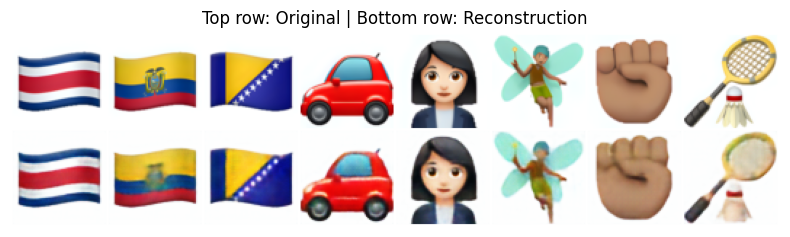

In [ ]:
visualize_reconstructions(vq_vae_model, train_loader, n=8)

In [ ]:
full_dataset = train_loader.dataset

total_size = len(full_dataset)
train_size = int(0.8 * total_size)
test_size = total_size - train_size

print(f"Total dataset size: {total_size}")
print(f"Train size: {train_size}")
print(f"Test size: {test_size}")

generator = torch.Generator().manual_seed(42)  # For reproducibility
train_dataset, test_dataset = random_split(
    full_dataset,
    [train_size, test_size],
    generator=generator
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print(f"\nTrain batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

Total dataset size: 2749
Train size: 2199
Test size: 550

Train batches: 18
Test batches: 5


In [ ]:
def extract_codes_from_dataset(model, dataloader, device):
    model.eval()
    all_codes = []

    with torch.no_grad():
        for imgs, _ in tqdm(dataloader, desc="Extracting codes"):
            imgs = imgs.to(device)
            z = model.encoder(imgs)
            _, _, indices = model.vq(z)
            all_codes.append(indices.cpu())

    all_codes = torch.cat(all_codes, dim=0)
    return all_codes

In [ ]:
print("Extracting train codes...")
train_codes = extract_codes_from_dataset(vq_vae_model, train_loader, DEVICE)
print(f"Train codes shape: {train_codes.shape}")

print("Extracting test codes...")
test_codes = extract_codes_from_dataset(vq_vae_model, test_loader, DEVICE)
print(f"Test codes shape: {test_codes.shape}")

Extracting train codes...


Extracting codes:   0%|          | 0/18 [00:00<?, ?it/s]

Train codes shape: torch.Size([2199, 16, 16])
Extracting test codes...


Extracting codes:   0%|          | 0/5 [00:00<?, ?it/s]

Test codes shape: torch.Size([550, 16, 16])


In [ ]:
class CodeDataset(Dataset):
    def __init__(self, codes):
        self.codes = codes.reshape(codes.shape[0], -1)  # (N, H*W)
        self.seq_len = self.codes.shape[1]

    def __len__(self):
        return len(self.codes)

    def __getitem__(self, idx):
        seq = self.codes[idx]
        return seq[:-1], seq[1:]  # input, target

In [ ]:
print("\n" + "="*50)
print("CREATING TRANSFORMER DATASETS")
print("="*50)

train_code_dataset = CodeDataset(train_codes)
test_code_dataset = CodeDataset(test_codes)

print(f"Train code dataset size: {len(train_code_dataset)}")
print(f"Test code dataset size: {len(test_code_dataset)}")
print(f"Sequence length: {train_code_dataset.seq_len}")

train_code_loader = DataLoader(
    train_code_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

test_code_loader = DataLoader(
    test_code_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

print(f"Train code batches: {len(train_code_loader)}")
print(f"Test code batches: {len(test_code_loader)}")
print("="*50)


CREATING TRANSFORMER DATASETS
Train code dataset size: 2199
Test code dataset size: 550
Sequence length: 256
Train code batches: 18
Test code batches: 5


In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class GPTTransformer(nn.Module):
    def __init__(self, vocab_size, d_model=256, nhead=8, num_layers=6,
                 dim_feedforward=1024, max_seq_len=256, dropout=0.1):
        super().__init__()

        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_seq_len)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )

        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(d_model, vocab_size)
        self.d_model = d_model

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def generate_square_subsequent_mask(self, sz):
        mask = torch.triu(torch.ones(sz, sz), diagonal=1)
        mask = mask.masked_fill(mask == 1, float('-inf'))
        return mask

    def forward(self, x):
        # x shape: (batch, seq_len)
        seq_len = x.size(1)

        # Create causal mask
        mask = self.generate_square_subsequent_mask(seq_len).to(x.device)

        # Embedding and positional encoding
        x = self.token_embedding(x) * math.sqrt(self.d_model)
        x = self.pos_encoding(x)

        # Transformer
        x = self.transformer(x, mask=mask, is_causal=True)

        # Output projection
        logits = self.fc_out(x)
        return logits

In [ ]:
vocab_size = NUM_EMBEDDINGS
seq_len = train_codes.shape[1] * train_codes.shape[2]

print(f"Vocabulary size: {vocab_size}")
print(f"Sequence length: {seq_len}")
print(f"Spatial dimensions: {train_codes.shape[1]} x {train_codes.shape[2]}")

# transformer = GPTTransformer(
#     vocab_size=vocab_size,
#     d_model=256,
#     nhead=8,
#     num_layers=6,
#     dim_feedforward=1024,
#     max_seq_len=seq_len,
#     dropout=0.1
# ).to(DEVICE)

transformer = GPTTransformer(
    vocab_size=vocab_size,
    d_model=128,  # REDUCE from 256
    nhead=4,      # REDUCE from 8
    num_layers=4,  # REDUCE from 6
    dim_feedforward=512,  # REDUCE from 1024
    max_seq_len=seq_len,
    dropout=0.2
).to(DEVICE)

print(f"Transformer parameters: {sum(p.numel() for p in transformer.parameters()):,}")

Vocabulary size: 512
Sequence length: 256
Spatial dimensions: 16 x 16
Transformer parameters: 924,672


In [ ]:
def train_transformer(model, train_loader, test_loader, vocab_size, num_epochs, device, lr=3e-4):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, betas=(0.9, 0.95), weight_decay=0.2)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        # ============ TRAINING PHASE ============
        model.train()
        total_train_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")

        for input_seq, target_seq in progress_bar:
            input_seq = input_seq.to(device)
            target_seq = target_seq.to(device)

            optimizer.zero_grad()

            # Forward pass
            logits = model(input_seq)

            # Compute loss
            loss = criterion(logits.reshape(-1, vocab_size), target_seq.reshape(-1))

            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            total_train_loss += loss.item()
            progress_bar.set_postfix({'train_loss': loss.item()})

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # ============ VALIDATION PHASE ============
        model.eval()
        total_test_loss = 0

        with torch.no_grad():
            for input_seq, target_seq in tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
                input_seq = input_seq.to(device)
                target_seq = target_seq.to(device)

                # Forward pass only
                logits = model(input_seq)
                loss = criterion(logits.reshape(-1, vocab_size), target_seq.reshape(-1))
                total_test_loss += loss.item()

        avg_test_loss = total_test_loss / len(test_loader)
        test_losses.append(avg_test_loss)

        scheduler.step()

        # Print both losses
        print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_test_loss:.4f}, LR = {scheduler.get_last_lr()[0]:.6f}")

        # Save checkpoint
        if (epoch + 1) % 10 == 0:
            torch.save({
                'epoch': epoch,
                'model_state': model.state_dict(),
                'optimizer_state': optimizer.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_test_loss,
            }, f"transformer_epoch_{epoch+1}.pt")
            print(f"✓ Checkpoint saved: transformer_epoch_{epoch+1}.pt")

    return model, train_losses, test_losses


In [ ]:
NUM_EPOCHS = 200
trained_transformer, train_losses, test_losses = train_transformer(
    transformer,
    train_code_loader,
    test_code_loader,
    vocab_size,
    NUM_EPOCHS,
    DEVICE,
    lr=1e-3
)

Epoch 1/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 1/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1: Train Loss = 6.0290, Val Loss = 5.6907, LR = 0.000300


Epoch 2/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 2/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2: Train Loss = 5.5715, Val Loss = 5.3029, LR = 0.000300


Epoch 3/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 3/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 3: Train Loss = 5.2553, Val Loss = 5.0264, LR = 0.000300


Epoch 4/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 4/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 4: Train Loss = 4.9897, Val Loss = 4.7821, LR = 0.000300


Epoch 5/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 5/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 5: Train Loss = 4.7657, Val Loss = 4.5774, LR = 0.000300


Epoch 6/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 6/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 6: Train Loss = 4.5670, Val Loss = 4.4068, LR = 0.000299


Epoch 7/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 7/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 7: Train Loss = 4.4074, Val Loss = 4.2783, LR = 0.000299


Epoch 8/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 8/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 8: Train Loss = 4.2727, Val Loss = 4.1734, LR = 0.000299


Epoch 9/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 9/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 9: Train Loss = 4.1806, Val Loss = 4.0863, LR = 0.000299


Epoch 10/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 10/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 10: Train Loss = 4.0909, Val Loss = 4.0114, LR = 0.000298
✓ Checkpoint saved: transformer_epoch_10.pt


Epoch 11/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 11/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 11: Train Loss = 4.0250, Val Loss = 3.9455, LR = 0.000298


Epoch 12/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 12/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 12: Train Loss = 3.9618, Val Loss = 3.8881, LR = 0.000297


Epoch 13/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 13/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 13: Train Loss = 3.8982, Val Loss = 3.8404, LR = 0.000297


Epoch 14/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 14/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 14: Train Loss = 3.8542, Val Loss = 3.7956, LR = 0.000296


Epoch 15/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 15/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 15: Train Loss = 3.8173, Val Loss = 3.7568, LR = 0.000296


Epoch 16/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 16/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 16: Train Loss = 3.7734, Val Loss = 3.7272, LR = 0.000295


Epoch 17/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 17/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 17: Train Loss = 3.7455, Val Loss = 3.6941, LR = 0.000295


Epoch 18/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 18/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 18: Train Loss = 3.6998, Val Loss = 3.6689, LR = 0.000294


Epoch 19/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 19/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 19: Train Loss = 3.6831, Val Loss = 3.6452, LR = 0.000293


Epoch 20/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 20/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 20: Train Loss = 3.6466, Val Loss = 3.6220, LR = 0.000293
✓ Checkpoint saved: transformer_epoch_20.pt


Epoch 21/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 21/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 21: Train Loss = 3.6264, Val Loss = 3.6004, LR = 0.000292


Epoch 22/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 22/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 22: Train Loss = 3.6060, Val Loss = 3.5809, LR = 0.000291


Epoch 23/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 23/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 23: Train Loss = 3.5804, Val Loss = 3.5679, LR = 0.000290


Epoch 24/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 24/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 24: Train Loss = 3.5592, Val Loss = 3.5491, LR = 0.000289


Epoch 25/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 25/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 25: Train Loss = 3.5464, Val Loss = 3.5348, LR = 0.000289


Epoch 26/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 26/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 26: Train Loss = 3.5342, Val Loss = 3.5180, LR = 0.000288


Epoch 27/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 27/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 27: Train Loss = 3.5144, Val Loss = 3.5051, LR = 0.000287


Epoch 28/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 28/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 28: Train Loss = 3.4999, Val Loss = 3.4941, LR = 0.000286


Epoch 29/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 29/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 29: Train Loss = 3.4853, Val Loss = 3.4791, LR = 0.000285


Epoch 30/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 30/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 30: Train Loss = 3.4690, Val Loss = 3.4676, LR = 0.000284
✓ Checkpoint saved: transformer_epoch_30.pt


Epoch 31/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 31/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 31: Train Loss = 3.4534, Val Loss = 3.4560, LR = 0.000283


Epoch 32/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 32/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 32: Train Loss = 3.4438, Val Loss = 3.4444, LR = 0.000281


Epoch 33/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 33/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 33: Train Loss = 3.4286, Val Loss = 3.4340, LR = 0.000280


Epoch 34/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 34/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 34: Train Loss = 3.4292, Val Loss = 3.4221, LR = 0.000279


Epoch 35/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 35/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 35: Train Loss = 3.4175, Val Loss = 3.4120, LR = 0.000278


Epoch 36/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 36/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 36: Train Loss = 3.3960, Val Loss = 3.4026, LR = 0.000277


Epoch 37/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 37/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 37: Train Loss = 3.3809, Val Loss = 3.3965, LR = 0.000275


Epoch 38/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 38/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 38: Train Loss = 3.3783, Val Loss = 3.3851, LR = 0.000274


Epoch 39/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 39/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 39: Train Loss = 3.3674, Val Loss = 3.3784, LR = 0.000273


Epoch 40/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 40/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 40: Train Loss = 3.3638, Val Loss = 3.3669, LR = 0.000271
✓ Checkpoint saved: transformer_epoch_40.pt


Epoch 41/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 41/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 41: Train Loss = 3.3466, Val Loss = 3.3604, LR = 0.000270


Epoch 42/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 42/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 42: Train Loss = 3.3322, Val Loss = 3.3535, LR = 0.000269


Epoch 43/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 43/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 43: Train Loss = 3.3229, Val Loss = 3.3465, LR = 0.000267


Epoch 44/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 44/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 44: Train Loss = 3.3221, Val Loss = 3.3373, LR = 0.000266


Epoch 45/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 45/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 45: Train Loss = 3.3130, Val Loss = 3.3308, LR = 0.000264


Epoch 46/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 46/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 46: Train Loss = 3.2931, Val Loss = 3.3239, LR = 0.000263


Epoch 47/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 47/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 47: Train Loss = 3.2918, Val Loss = 3.3153, LR = 0.000261


Epoch 48/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 48/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 48: Train Loss = 3.2824, Val Loss = 3.3079, LR = 0.000259


Epoch 49/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 49/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 49: Train Loss = 3.2746, Val Loss = 3.3001, LR = 0.000258


Epoch 50/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 50/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 50: Train Loss = 3.2735, Val Loss = 3.2955, LR = 0.000256
✓ Checkpoint saved: transformer_epoch_50.pt


Epoch 51/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 51/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 51: Train Loss = 3.2678, Val Loss = 3.2881, LR = 0.000254


Epoch 52/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 52/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 52: Train Loss = 3.2551, Val Loss = 3.2798, LR = 0.000253


Epoch 53/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 53/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 53: Train Loss = 3.2596, Val Loss = 3.2739, LR = 0.000251


Epoch 54/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 54/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 54: Train Loss = 3.2399, Val Loss = 3.2742, LR = 0.000249


Epoch 55/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 55/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 55: Train Loss = 3.2376, Val Loss = 3.2635, LR = 0.000247


Epoch 56/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 56/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 56: Train Loss = 3.2238, Val Loss = 3.2589, LR = 0.000246


Epoch 57/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 57/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 57: Train Loss = 3.2159, Val Loss = 3.2518, LR = 0.000244


Epoch 58/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 58/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 58: Train Loss = 3.2079, Val Loss = 3.2462, LR = 0.000242


Epoch 59/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 59/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 59: Train Loss = 3.2113, Val Loss = 3.2413, LR = 0.000240


Epoch 60/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 60/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 60: Train Loss = 3.1979, Val Loss = 3.2368, LR = 0.000238
✓ Checkpoint saved: transformer_epoch_60.pt


Epoch 61/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 61/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 61: Train Loss = 3.1980, Val Loss = 3.2300, LR = 0.000236


Epoch 62/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 62/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 62: Train Loss = 3.2000, Val Loss = 3.2231, LR = 0.000234


Epoch 63/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 63/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 63: Train Loss = 3.1798, Val Loss = 3.2200, LR = 0.000232


Epoch 64/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 64/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 64: Train Loss = 3.1750, Val Loss = 3.2145, LR = 0.000230


Epoch 65/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 65/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 65: Train Loss = 3.1723, Val Loss = 3.2101, LR = 0.000228


Epoch 66/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 66/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 66: Train Loss = 3.1670, Val Loss = 3.2069, LR = 0.000226


Epoch 67/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 67/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 67: Train Loss = 3.1584, Val Loss = 3.2033, LR = 0.000224


Epoch 68/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 68/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 68: Train Loss = 3.1556, Val Loss = 3.1952, LR = 0.000222


Epoch 69/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 69/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 69: Train Loss = 3.1608, Val Loss = 3.1907, LR = 0.000220


Epoch 70/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 70/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 70: Train Loss = 3.1509, Val Loss = 3.1877, LR = 0.000218
✓ Checkpoint saved: transformer_epoch_70.pt


Epoch 71/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 71/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 71: Train Loss = 3.1329, Val Loss = 3.1848, LR = 0.000216


Epoch 72/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 72/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 72: Train Loss = 3.1389, Val Loss = 3.1784, LR = 0.000214


Epoch 73/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 73/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 73: Train Loss = 3.1294, Val Loss = 3.1755, LR = 0.000212


Epoch 74/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 74/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 74: Train Loss = 3.1239, Val Loss = 3.1724, LR = 0.000210


Epoch 75/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 75/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 75: Train Loss = 3.1045, Val Loss = 3.1685, LR = 0.000207


Epoch 76/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 76/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 76: Train Loss = 3.1126, Val Loss = 3.1642, LR = 0.000205


Epoch 77/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 77/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 77: Train Loss = 3.1031, Val Loss = 3.1605, LR = 0.000203


Epoch 78/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 78/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 78: Train Loss = 3.1020, Val Loss = 3.1585, LR = 0.000201


Epoch 79/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 79/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 79: Train Loss = 3.1127, Val Loss = 3.1537, LR = 0.000199


Epoch 80/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 80/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 80: Train Loss = 3.0999, Val Loss = 3.1489, LR = 0.000196
✓ Checkpoint saved: transformer_epoch_80.pt


Epoch 81/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 81/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 81: Train Loss = 3.0978, Val Loss = 3.1472, LR = 0.000194


Epoch 82/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 82/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 82: Train Loss = 3.0902, Val Loss = 3.1431, LR = 0.000192


Epoch 83/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 83/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 83: Train Loss = 3.0833, Val Loss = 3.1428, LR = 0.000190


Epoch 84/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 84/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 84: Train Loss = 3.0710, Val Loss = 3.1390, LR = 0.000187


Epoch 85/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 85/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 85: Train Loss = 3.0754, Val Loss = 3.1337, LR = 0.000185


Epoch 86/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 86/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 86: Train Loss = 3.0636, Val Loss = 3.1314, LR = 0.000183


Epoch 87/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 87/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 87: Train Loss = 3.0654, Val Loss = 3.1273, LR = 0.000180


Epoch 88/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 88/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 88: Train Loss = 3.0651, Val Loss = 3.1258, LR = 0.000178


Epoch 89/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 89/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 89: Train Loss = 3.0543, Val Loss = 3.1225, LR = 0.000176


Epoch 90/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 90/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 90: Train Loss = 3.0562, Val Loss = 3.1199, LR = 0.000173
✓ Checkpoint saved: transformer_epoch_90.pt


Epoch 91/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 91/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 91: Train Loss = 3.0517, Val Loss = 3.1159, LR = 0.000171


Epoch 92/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 92/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 92: Train Loss = 3.0596, Val Loss = 3.1133, LR = 0.000169


Epoch 93/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 93/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 93: Train Loss = 3.0455, Val Loss = 3.1140, LR = 0.000166


Epoch 94/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 94/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 94: Train Loss = 3.0430, Val Loss = 3.1098, LR = 0.000164


Epoch 95/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 95/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 95: Train Loss = 3.0237, Val Loss = 3.1072, LR = 0.000162


Epoch 96/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 96/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 96: Train Loss = 3.0346, Val Loss = 3.1043, LR = 0.000159


Epoch 97/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 97/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 97: Train Loss = 3.0355, Val Loss = 3.1019, LR = 0.000157


Epoch 98/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 98/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 98: Train Loss = 3.0312, Val Loss = 3.1000, LR = 0.000155


Epoch 99/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 99/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 99: Train Loss = 3.0186, Val Loss = 3.0980, LR = 0.000152


Epoch 100/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 100/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 100: Train Loss = 3.0304, Val Loss = 3.0963, LR = 0.000150
✓ Checkpoint saved: transformer_epoch_100.pt


Epoch 101/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 101/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 101: Train Loss = 3.0235, Val Loss = 3.0924, LR = 0.000148


Epoch 102/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 102/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 102: Train Loss = 3.0183, Val Loss = 3.0919, LR = 0.000145


Epoch 103/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 103/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 103: Train Loss = 3.0235, Val Loss = 3.0904, LR = 0.000143


Epoch 104/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 104/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 104: Train Loss = 3.0060, Val Loss = 3.0876, LR = 0.000141


Epoch 105/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 105/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 105: Train Loss = 3.0136, Val Loss = 3.0861, LR = 0.000138


Epoch 106/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 106/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 106: Train Loss = 3.0226, Val Loss = 3.0851, LR = 0.000136


Epoch 107/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 107/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 107: Train Loss = 3.0114, Val Loss = 3.0835, LR = 0.000134


Epoch 108/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 108/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 108: Train Loss = 3.0055, Val Loss = 3.0800, LR = 0.000131


Epoch 109/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 109/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 109: Train Loss = 2.9999, Val Loss = 3.0795, LR = 0.000129


Epoch 110/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 110/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 110: Train Loss = 2.9964, Val Loss = 3.0758, LR = 0.000127
✓ Checkpoint saved: transformer_epoch_110.pt


Epoch 111/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 111/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 111: Train Loss = 2.9971, Val Loss = 3.0747, LR = 0.000124


Epoch 112/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 112/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 112: Train Loss = 2.9965, Val Loss = 3.0735, LR = 0.000122


Epoch 113/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 113/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 113: Train Loss = 2.9917, Val Loss = 3.0740, LR = 0.000120


Epoch 114/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 114/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 114: Train Loss = 2.9888, Val Loss = 3.0726, LR = 0.000117


Epoch 115/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 115/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 115: Train Loss = 2.9865, Val Loss = 3.0691, LR = 0.000115


Epoch 116/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 116/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 116: Train Loss = 2.9866, Val Loss = 3.0673, LR = 0.000113


Epoch 117/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 117/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 117: Train Loss = 2.9848, Val Loss = 3.0664, LR = 0.000110


Epoch 118/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 118/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 118: Train Loss = 2.9802, Val Loss = 3.0662, LR = 0.000108


Epoch 119/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 119/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 119: Train Loss = 2.9800, Val Loss = 3.0647, LR = 0.000106


Epoch 120/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 120/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 120: Train Loss = 2.9832, Val Loss = 3.0626, LR = 0.000104
✓ Checkpoint saved: transformer_epoch_120.pt


Epoch 121/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 121/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 121: Train Loss = 2.9918, Val Loss = 3.0608, LR = 0.000101


Epoch 122/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 122/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 122: Train Loss = 2.9791, Val Loss = 3.0601, LR = 0.000099


Epoch 123/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 123/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 123: Train Loss = 2.9812, Val Loss = 3.0583, LR = 0.000097


Epoch 124/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 124/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 124: Train Loss = 2.9704, Val Loss = 3.0590, LR = 0.000095


Epoch 125/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 125/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 125: Train Loss = 2.9616, Val Loss = 3.0563, LR = 0.000093


Epoch 126/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 126/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 126: Train Loss = 2.9630, Val Loss = 3.0566, LR = 0.000090


Epoch 127/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 127/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 127: Train Loss = 2.9755, Val Loss = 3.0531, LR = 0.000088


Epoch 128/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 128/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 128: Train Loss = 2.9642, Val Loss = 3.0531, LR = 0.000086


Epoch 129/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 129/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 129: Train Loss = 2.9596, Val Loss = 3.0521, LR = 0.000084


Epoch 130/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 130/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 130: Train Loss = 2.9626, Val Loss = 3.0505, LR = 0.000082
✓ Checkpoint saved: transformer_epoch_130.pt


Epoch 131/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 131/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 131: Train Loss = 2.9613, Val Loss = 3.0501, LR = 0.000080


Epoch 132/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 132/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 132: Train Loss = 2.9657, Val Loss = 3.0490, LR = 0.000078


Epoch 133/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 133/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 133: Train Loss = 2.9596, Val Loss = 3.0487, LR = 0.000076


Epoch 134/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 134/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 134: Train Loss = 2.9553, Val Loss = 3.0476, LR = 0.000074


Epoch 135/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 135/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 135: Train Loss = 2.9624, Val Loss = 3.0469, LR = 0.000072


Epoch 136/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 136/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 136: Train Loss = 2.9479, Val Loss = 3.0447, LR = 0.000070


Epoch 137/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 137/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 137: Train Loss = 2.9474, Val Loss = 3.0440, LR = 0.000068


Epoch 138/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 138/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 138: Train Loss = 2.9472, Val Loss = 3.0436, LR = 0.000066


Epoch 139/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 139/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 139: Train Loss = 2.9615, Val Loss = 3.0430, LR = 0.000064


Epoch 140/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 140/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 140: Train Loss = 2.9457, Val Loss = 3.0422, LR = 0.000062
✓ Checkpoint saved: transformer_epoch_140.pt


Epoch 141/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 141/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 141: Train Loss = 2.9504, Val Loss = 3.0426, LR = 0.000060


Epoch 142/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 142/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 142: Train Loss = 2.9394, Val Loss = 3.0403, LR = 0.000058


Epoch 143/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 143/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 143: Train Loss = 2.9502, Val Loss = 3.0398, LR = 0.000056


Epoch 144/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 144/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 144: Train Loss = 2.9394, Val Loss = 3.0395, LR = 0.000054


Epoch 145/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 145/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 145: Train Loss = 2.9303, Val Loss = 3.0394, LR = 0.000053


Epoch 146/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 146/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 146: Train Loss = 2.9479, Val Loss = 3.0385, LR = 0.000051


Epoch 147/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 147/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 147: Train Loss = 2.9361, Val Loss = 3.0375, LR = 0.000049


Epoch 148/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 148/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 148: Train Loss = 2.9407, Val Loss = 3.0361, LR = 0.000047


Epoch 149/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 149/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 149: Train Loss = 2.9448, Val Loss = 3.0364, LR = 0.000046


Epoch 150/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 150/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 150: Train Loss = 2.9467, Val Loss = 3.0358, LR = 0.000044
✓ Checkpoint saved: transformer_epoch_150.pt


Epoch 151/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 151/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 151: Train Loss = 2.9320, Val Loss = 3.0354, LR = 0.000042


Epoch 152/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 152/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 152: Train Loss = 2.9434, Val Loss = 3.0343, LR = 0.000041


Epoch 153/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 153/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 153: Train Loss = 2.9395, Val Loss = 3.0341, LR = 0.000039


Epoch 154/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 154/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 154: Train Loss = 2.9387, Val Loss = 3.0342, LR = 0.000037


Epoch 155/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 155/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 155: Train Loss = 2.9288, Val Loss = 3.0336, LR = 0.000036


Epoch 156/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 156/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 156: Train Loss = 2.9368, Val Loss = 3.0334, LR = 0.000034


Epoch 157/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 157/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 157: Train Loss = 2.9286, Val Loss = 3.0326, LR = 0.000033


Epoch 158/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 158/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 158: Train Loss = 2.9387, Val Loss = 3.0327, LR = 0.000031


Epoch 159/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 159/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 159: Train Loss = 2.9307, Val Loss = 3.0317, LR = 0.000030


Epoch 160/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 160/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 160: Train Loss = 2.9303, Val Loss = 3.0315, LR = 0.000029
✓ Checkpoint saved: transformer_epoch_160.pt


Epoch 161/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 161/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 161: Train Loss = 2.9397, Val Loss = 3.0312, LR = 0.000027


Epoch 162/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 162/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 162: Train Loss = 2.9292, Val Loss = 3.0308, LR = 0.000026


Epoch 163/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 163/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 163: Train Loss = 2.9350, Val Loss = 3.0308, LR = 0.000025


Epoch 164/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 164/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 164: Train Loss = 2.9218, Val Loss = 3.0298, LR = 0.000023


Epoch 165/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 165/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 165: Train Loss = 2.9342, Val Loss = 3.0302, LR = 0.000022


Epoch 166/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 166/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 166: Train Loss = 2.9158, Val Loss = 3.0298, LR = 0.000021


Epoch 167/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 167/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 167: Train Loss = 2.9380, Val Loss = 3.0296, LR = 0.000020


Epoch 168/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 168/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 168: Train Loss = 2.9285, Val Loss = 3.0296, LR = 0.000019


Epoch 169/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 169/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 169: Train Loss = 2.9233, Val Loss = 3.0296, LR = 0.000017


Epoch 170/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 170/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 170: Train Loss = 2.9301, Val Loss = 3.0286, LR = 0.000016
✓ Checkpoint saved: transformer_epoch_170.pt


Epoch 171/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 171/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 171: Train Loss = 2.9309, Val Loss = 3.0292, LR = 0.000015


Epoch 172/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 172/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 172: Train Loss = 2.9295, Val Loss = 3.0289, LR = 0.000014


Epoch 173/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 173/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 173: Train Loss = 2.9303, Val Loss = 3.0285, LR = 0.000013


Epoch 174/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 174/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 174: Train Loss = 2.9194, Val Loss = 3.0283, LR = 0.000012


Epoch 175/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 175/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 175: Train Loss = 2.9273, Val Loss = 3.0280, LR = 0.000011


Epoch 176/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 176/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 176: Train Loss = 2.9268, Val Loss = 3.0283, LR = 0.000011


Epoch 177/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 177/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 177: Train Loss = 2.9220, Val Loss = 3.0278, LR = 0.000010


Epoch 178/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 178/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 178: Train Loss = 2.9264, Val Loss = 3.0280, LR = 0.000009


Epoch 179/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 179/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 179: Train Loss = 2.9233, Val Loss = 3.0280, LR = 0.000008


Epoch 180/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 180/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 180: Train Loss = 2.9279, Val Loss = 3.0276, LR = 0.000007
✓ Checkpoint saved: transformer_epoch_180.pt


Epoch 181/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 181/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 181: Train Loss = 2.9277, Val Loss = 3.0278, LR = 0.000007


Epoch 182/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 182/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 182: Train Loss = 2.9273, Val Loss = 3.0274, LR = 0.000006


Epoch 183/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 183/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 183: Train Loss = 2.9278, Val Loss = 3.0274, LR = 0.000005


Epoch 184/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 184/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 184: Train Loss = 2.9236, Val Loss = 3.0275, LR = 0.000005


Epoch 185/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 185/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 185: Train Loss = 2.9277, Val Loss = 3.0272, LR = 0.000004


Epoch 186/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 186/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 186: Train Loss = 2.9202, Val Loss = 3.0274, LR = 0.000004


Epoch 187/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 187/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 187: Train Loss = 2.9202, Val Loss = 3.0271, LR = 0.000003


Epoch 188/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 188/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 188: Train Loss = 2.9289, Val Loss = 3.0272, LR = 0.000003


Epoch 189/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 189/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 189: Train Loss = 2.9221, Val Loss = 3.0271, LR = 0.000002


Epoch 190/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 190/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 190: Train Loss = 2.9320, Val Loss = 3.0272, LR = 0.000002
✓ Checkpoint saved: transformer_epoch_190.pt


Epoch 191/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 191/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 191: Train Loss = 2.9366, Val Loss = 3.0272, LR = 0.000001


Epoch 192/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 192/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 192: Train Loss = 2.9327, Val Loss = 3.0271, LR = 0.000001


Epoch 193/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 193/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 193: Train Loss = 2.9165, Val Loss = 3.0271, LR = 0.000001


Epoch 194/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 194/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 194: Train Loss = 2.9266, Val Loss = 3.0271, LR = 0.000001


Epoch 195/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 195/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 195: Train Loss = 2.9293, Val Loss = 3.0270, LR = 0.000000


Epoch 196/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 196/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 196: Train Loss = 2.9176, Val Loss = 3.0271, LR = 0.000000


Epoch 197/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 197/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 197: Train Loss = 2.9346, Val Loss = 3.0271, LR = 0.000000


Epoch 198/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 198/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 198: Train Loss = 2.9219, Val Loss = 3.0271, LR = 0.000000


Epoch 199/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 199/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 199: Train Loss = 2.9214, Val Loss = 3.0271, LR = 0.000000


Epoch 200/200 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 200/200 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 200: Train Loss = 2.9226, Val Loss = 3.0271, LR = 0.000000
✓ Checkpoint saved: transformer_epoch_200.pt


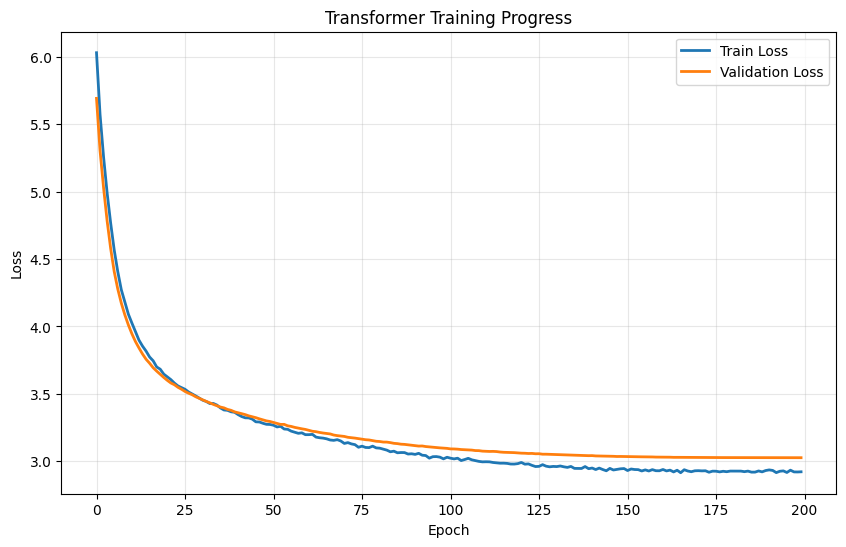

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(test_losses, label='Validation Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Transformer Training Progress')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
vocab_size = NUM_EMBEDDINGS
seq_len = train_codes.shape[1] * train_codes.shape[2]

transformer = GPTTransformer(
    vocab_size=vocab_size,
    d_model=256,
    nhead=8,
    num_layers=6,
    dim_feedforward=1024,
    max_seq_len=seq_len,
    dropout=0.1
).to(DEVICE)

checkpoint_path = "transformer_epoch_50.pt"
print(f"Loading checkpoint: {checkpoint_path}")

checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
transformer.load_state_dict(checkpoint['model_state'])

print(f"✓ Checkpoint loaded from epoch {checkpoint['epoch']}")
print(f"  - Train Loss: {checkpoint.get('train_loss', 'N/A'):.4f}")
print(f"  - Val Loss: {checkpoint.get('val_loss', 'N/A'):.4f}")

In [ ]:
@torch.no_grad()
def generate_samples(transformer_model, vqvae_model, num_samples, seq_len,
                     spatial_size, temperature=1.0, top_k=None, device=DEVICE):
    transformer_model.eval()
    vqvae_model.eval()

    generated_images = []

    for _ in tqdm(range(num_samples), desc="Generating samples"):
        # Start with random token or special start token
        generated_seq = torch.randint(0, vocab_size, (1, 1)).to(device)

        # Autoregressively generate sequence
        for _ in range(seq_len - 1):
            logits = transformer_model(generated_seq)
            next_token_logits = logits[:, -1, :] / temperature

            # Apply top-k filtering
            if top_k is not None:
                indices_to_remove = next_token_logits < torch.topk(next_token_logits, top_k)[0][..., -1, None]
                next_token_logits[indices_to_remove] = float('-inf')

            # Sample from distribution
            probs = torch.softmax(next_token_logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)

            generated_seq = torch.cat([generated_seq, next_token], dim=1)

        # Reshape to spatial dimensions
        code_indices = generated_seq.squeeze(0).reshape(spatial_size)

        # Get embeddings from codebook
        quantized = vqvae_model.vq.embedding[code_indices]
        quantized = quantized.permute(2, 0, 1).unsqueeze(0)  # (1, C, H, W)

        # Decode to image
        reconstructed = vqvae_model.decoder(quantized)
        generated_images.append(reconstructed.squeeze(0).cpu())

    return torch.stack(generated_images)



In [ ]:
def generate_with_diversity(transformer_model, vqvae_model, num_samples,
                            spatial_size, temperatures=[0.7, 0.9, 1.1]):
    all_samples = []

    for temp in temperatures:
        samples = generate_samples(
            transformer_model, vqvae_model,
            num_samples=num_samples // len(temperatures),
            seq_len=spatial_size[0] * spatial_size[1],
            spatial_size=spatial_size,
            temperature=temp,
            top_k=50
        )
        all_samples.append(samples)

    return torch.cat(all_samples, dim=0)


Generating 64 novel emojis...


Generating samples:   0%|          | 0/64 [00:00<?, ?it/s]

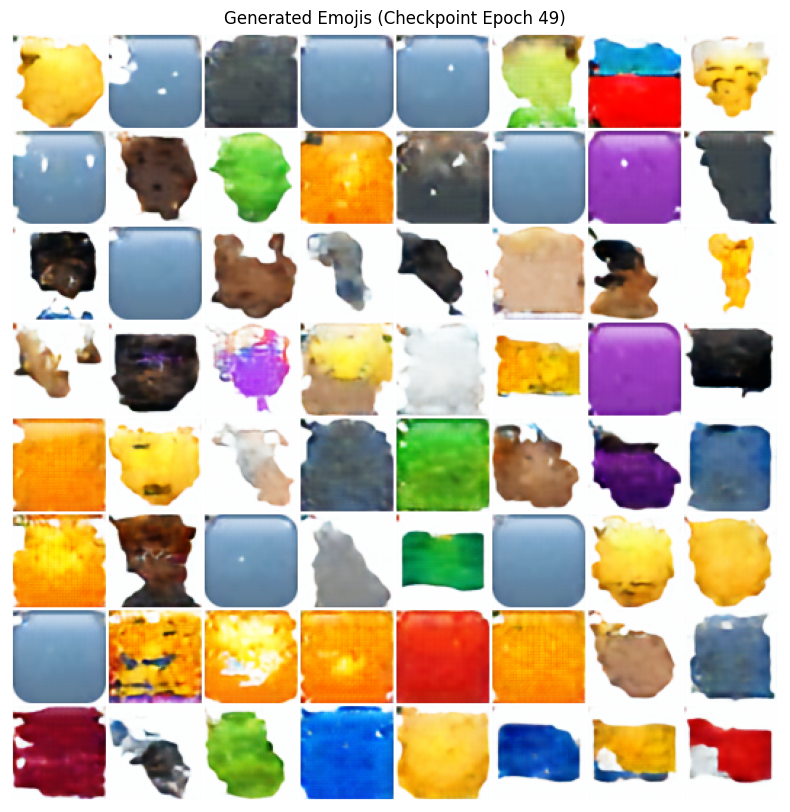

In [ ]:
transformer.eval()

H, W = train_codes.shape[1], train_codes.shape[2]

print(f"\nGenerating {64} novel emojis...")
generated_emojis = generate_samples(
    transformer,
    vq_vae_model,
    num_samples=64,
    seq_len=H * W,
    spatial_size=(H, W),
    temperature=0.8,
    top_k=100,
    device=DEVICE
)

show_image_tensor_grid(generated_emojis, ncols=8, title=f"Generated Emojis (Checkpoint Epoch {checkpoint['epoch']})")

Generating samples:   0%|          | 0/64 [00:00<?, ?it/s]

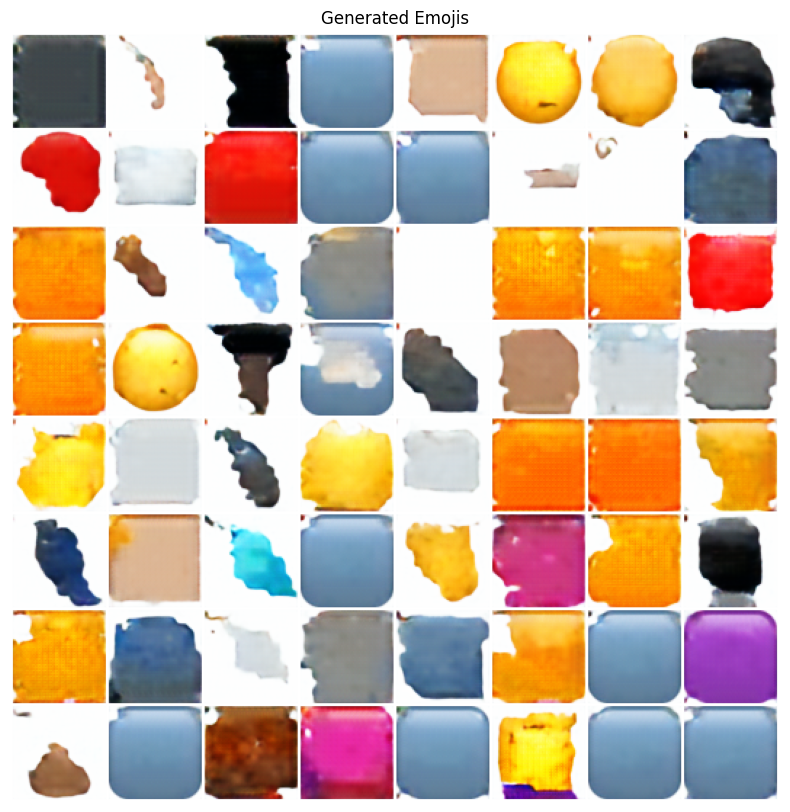

In [ ]:
H, W = train_codes.shape[1], train_codes.shape[2]

generated_emojis = generate_samples(
    trained_transformer,
    vq_vae_model,
    num_samples=64,
    seq_len=H * W,
    spatial_size=(H, W),
    temperature=0.6,
    top_k=100,
    device=DEVICE
)

show_image_tensor_grid(generated_emojis, ncols=8, title="Generated Emojis")

Generating samples:   0%|          | 0/6 [00:00<?, ?it/s]

Generating samples:   0%|          | 0/6 [00:00<?, ?it/s]

Generating samples:   0%|          | 0/6 [00:00<?, ?it/s]

Generating samples:   0%|          | 0/6 [00:00<?, ?it/s]

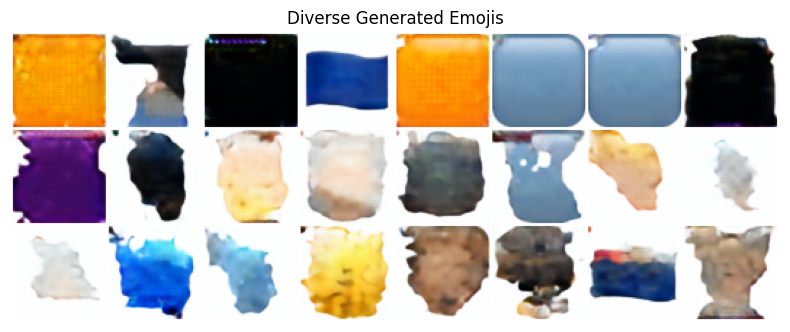

In [ ]:
diverse_emojis = generate_with_diversity(
    trained_transformer, vq_vae_model,
    num_samples=24,
    spatial_size=(H, W),
    temperatures=[0.5, 0.7, 0.9, 1.1]
)

show_image_tensor_grid(diverse_emojis, ncols=8, title="Diverse Generated Emojis")